Сперва устанавливаем необходимые библиотеки

In [1]:
pip install Levenshtein


In [5]:
pip install noisereduce

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import Levenshtein
import warnings
import gc
from scipy.signal import medfilt, butter, sosfilt, t, periodogram
from pathlib import Path
import zipfile
import io



warnings.filterwarnings('ignore')

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")



Используется устройство: cuda


In [ ]:
# Глобальные переменные

TEST_CSV = "/content/drive/MyDrive/kontur/test.csv"
ZIP_PATH = '/content/drive/MyDrive/kontur/morse_dataset.zip'
BASE_DIR = 'morse_dataset/' 
DATA_DIR = "../input/morse1/morse_dataset/morse_dataset"
CSV_FILE = "/content/drive/MyDrive/kontur/train.csv"
PROCESSED_DATA = "/content/drive/MyDrive/kontur/processed.parquet"
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 5  # Количество эпох без улучшения перед остановкой
VALID_SIZE = 0.1

In [4]:
# Загрузка трэйн-CSV файла
df = pd.read_csv(CSV_FILE)
print(f"Загружено {len(df)} примеров из CSV файла")
print(df.head())

# Определение словаря символов
CHARS = ['<blank>', ' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н',
         'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы',
         'Ь', 'Э', 'Ю', 'Я']

# Создаем словари для конвертации символов в индексы и обратно
char_to_idx = {char: idx for idx, char in enumerate(CHARS)}
idx_to_char = {idx: char for idx, char in enumerate(CHARS)}

print(f"Общее количество символов: {len(CHARS)}")

Загружено 30000 примеров из CSV файла
       id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ
Общее количество символов: 45


Ниже в ячейке производим предобработку сигнала - находим доминирующую частоту и применяем полосовой фильтр в окрестностях данной частоты, с целью удаления шума. После этого извлекаем признаки.  На первоначальном этапе проводился абляционный прогон в ходе которого были удалены ряд признаков отрицательно влияющих на результат (mel высокой размерности, bandwidth ит.д.)              
                      config  valid_loss  valid_dist
0                      all    0.147297    0.336667
1           all_minus_mfcc    0.140590    0.308000
2          all_minus_delta    0.148802    0.317667
3         all_minus_delta2    0.135243    0.311667
4      all_minus_log_mel12    0.151838    0.318333
5      all_minus_log_mel24    0.138677    0.318000
6       all_minus_centroid    0.140199    0.325667
7      all_minus_bandwidth    0.123273    0.297000
8            all_minus_rms    0.145063    0.335333
9            all_minus_zcr    0.144540    0.324000
10     all_minus_env_feats    0.135479    0.311667
11  all_minus_timing_stats    0.140990    0.316667

![alt text](image-2.png)


In [ ]:


# Параметры обработки сигнала
PREEMPHASIS = 0.97
N_MFCC      = 12
N_FFT       = 512
HOP_LENGTH  = 256
FMAX        = 2000

def find_dominant_freq(signal, sr, min_freq=100, max_freq=2000):
    """Находит доминирующую частоту в заданном диапазоне"""
    freqs = np.fft.rfftfreq(len(signal), 1/sr)
    fft   = np.abs(np.fft.rfft(signal))
    mask  = (freqs >= min_freq) & (freqs <= max_freq)
    if not np.any(mask):
        return 700, None
    freqs, fft = freqs[mask], fft[mask]
    return freqs[np.argmax(fft)], None

def extract_features_enhanced(y, sr=16000,  morse_speed='auto'):
    
    #  полосовой фильтр вокруг частоты ±15 Гц (данный диапазон определен эмпирически в ходе предобработки )
    f0, _ = find_dominant_freq(y, sr, min_freq=100, max_freq=2000)
    lowcut  = max(0,          f0 - 15)
    highcut = min(sr / 2.0,   f0 + 15)
    b_bp, a_bp = butter(4, [lowcut, highcut], btype='bandpass', fs=sr)
    y = filtfilt(b_bp, a_bp, y)


    # Pre‑emphasis + normalize
    y = librosa.effects.preemphasis(y=y, coef=PREEMPHASIS)
    y = librosa.util.normalize(y)

    if morse_speed == 'auto':
        # Оценка скорости по частоте перехода через ноль
        zero_crossings = np.sum(np.abs(np.diff(np.sign(y))) > 0)
        speed_factor = zero_crossings / len(y)

        if speed_factor > 0.1:  # Быстрая морзянка
            current_hop_length = 128
        else:  # Медленная морзянка
            current_hop_length = 256
    elif morse_speed == 'fast':
        current_hop_length = 128
    else:  # slow
        current_hop_length = 256

    # Демодуляция огибающей
    f, P = periodogram(x=y, fs=sr, window='blackman', nfft=8192, scaling='spectrum')
    tone = f[np.argmax(P)]
    t = np.arange(len(y)) / sr
    mixed = y * (1 + np.sin(2*np.pi*tone*t)) / 2
    cutoff = 40 if current_hop_length <= 128 else 25
    b, a = butter(3, cutoff/(sr/2), btype='low')
    env = filtfilt(b, a, np.abs(mixed))
    env_dec = env[::HOP_LENGTH]
    if env_dec.max() > 0:
        env_dec /= env_dec.max()
    env_delta = np.diff(env_dec, prepend=env_dec[0])  
    env_stats = np.array([
        np.mean(env_dec),
        np.std(env_dec),
        np.max(env_dec) - np.min(env_dec)
    ])[:, np.newaxis].repeat(len(env_dec), axis=1)

    env_feats = np.vstack([
        env_dec,                # Сама огибающая
        env_delta,              # Производная огибающей (для определения границ)
        env_stats               # Статистики огибающей
    ])  # (5, T_env)

    # MFCC + дельты + delta2
    mfcc   = librosa.feature.mfcc(y=y, sr=sr,
                                  n_mfcc=N_MFCC,
                                  n_fft=N_FFT,
                                  hop_length=HOP_LENGTH,
                                  fmax=FMAX)
    delta  = librosa.feature.delta(mfcc, width=5)
    delta2 = librosa.feature.delta(mfcc, order=2, width=5)

    #  Mel: 24 и 12 фильтров (точный и грубый фильтр)
    mel24 = librosa.feature.melspectrogram(y=y, sr=sr,
                                           n_fft=N_FFT,
                                           hop_length=HOP_LENGTH,
                                           n_mels=24,
                                           fmax=FMAX)
    mel12 = librosa.feature.melspectrogram(y=y, sr=sr,
                                           n_fft=N_FFT,
                                           hop_length=HOP_LENGTH,
                                           n_mels=12,
                                           fmax=FMAX)
    log_mel24 = librosa.power_to_db(mel24, ref=np.max)
    log_mel12 = librosa.power_to_db(mel12, ref=np.max)

    # Спектральные признаки
    centroid  = librosa.feature.spectral_centroid(y=y, sr=sr,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)

    rolloff   = librosa.feature.spectral_rolloff(y=y, sr=sr,
                                                 n_fft=N_FFT, hop_length=HOP_LENGTH)
    binary_env = (env_dec > 0.3).astype(float)

    # Находим длины интервалов
    signal_lengths = []
    silence_lengths = []
    current_state = 0
    current_length = 0

    for bit in binary_env:
        if bit == current_state:
            current_length += 1
        else:
            if current_state == 1:
                signal_lengths.append(current_length)
            else:
                silence_lengths.append(current_length)
            current_state = bit
            current_length = 1

    # Добавляем последний интервал
    if current_length > 0:
        if current_state == 1:
            signal_lengths.append(current_length)
        else:
            silence_lengths.append(current_length)
     # Создаем гистограммы длин (помогают классифицировать точки, тире и паузы)
    if signal_lengths:
        sig_mean = np.mean(signal_lengths)
        sig_std = np.std(signal_lengths) if len(signal_lengths) > 1 else 1.0
    else:
        sig_mean, sig_std = 0, 1

    if silence_lengths:
        sil_mean = np.mean(silence_lengths)
        sil_std = np.std(silence_lengths) if len(silence_lengths) > 1 else 1.0
    else:
        sil_mean, sil_std = 0, 1

    # Масштабированная гистограмма интервалов
    timing_stats = np.array([
        sig_mean / current_hop_length,
        sig_std / current_hop_length,
        sil_mean / current_hop_length,
        sil_std / current_hop_length
    ])[:, np.newaxis].repeat(binary_env.shape[0], axis=1)

    # Энергетические признаки
    rms = librosa.feature.rms(y=y, frame_length=N_FFT, hop_length=HOP_LENGTH)
    zcr = librosa.feature.zero_crossing_rate(y=y,
                                             frame_length=N_FFT,
                                             hop_length=HOP_LENGTH)

    #  все признаки в сборе
    feat_list = [
        mfcc,           # Мел-кепстральные коэффициенты (12)
        delta,          # Дельты MFCC (12)
        delta2,         # Дельты второго порядка (12)
        log_mel12,      # Малое мел-разрешение (12)
        log_mel24,      # Среднее мел-разрешение (24)
        centroid,       # Спектральный центроид (1)

        rms,            # Энергия (1)
        zcr,            # Частота перехода через ноль (1)
        env_feats,      # Признаки огибающей (5)
        timing_stats    # Признаки временных интервалов (4)
    ]

    # 9) Отсекаем до минимальной длины T
    min_T = min(f.shape[1] for f in feat_list)
    feat_list = [f[:, :min_T] for f in feat_list]

    # 10) Конкатенируем признаки
    features = np.concatenate(feat_list, axis=0)
    features = (features - features.mean(axis=1, keepdims=True)) / \
               (features.std(axis=1, keepdims=True) + 1e-6)

    return features.T  


In [ ]:
#экстрактируем признаки

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    archive_names = zf.namelist()

records = []
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Предобработка"):
        fn, msg = row['id'], row['message']
        # Ищем полный путь внутри архива
        matches = [name for name in archive_names if name.endswith('/' + fn)]
        if not matches:
            continue
        # Открываем файл из архива и читаем байты
        with zf.open(matches[0]) as af:
            raw = af.read()
        # Загружаем сигнал из байтового потока
        y, sr = librosa.load(io.BytesIO(raw), sr=16000)
        # Извлекаем признаки
        feats = extract_features_enhanced(y, sr)
        # Добавляем в список
        records.append({
            'features': feats,   # np.ndarray (T, feature_dim)
            'message': msg       # строка
        })

if not records:
    raise RuntimeError("Ни одного файла не обработано")





Предобработка: 100%|██████████| 30000/30000 [58:21<00:00,  8.57it/s]


In [ ]:
# опцпионально десериализуем и  сохраняем в паркет
'''

processed_df = pd.DataFrame(records)

processed_df['feature_shape'] = processed_df['features'].apply(lambda x: x.shape)


processed_df['features_bytes'] = processed_df['features']\
    .apply(lambda x: x.astype(np.float32).tobytes())


processed_df = processed_df.drop(columns=['features'])


processed_df.to_parquet('21_04_2.parquet', index=False)
'''


In [ ]:
'''
df = pd.read_parquet('21_04.parquet')

def _deserialize(row):
    arr = np.frombuffer(row['features_bytes'], dtype=np.float32)
    return arr.reshape(row['feature_shape'])

df['features'] = df.apply(_deserialize, axis=1)
'''

In [ ]:
# сплит на  train и val датасеты. При предварительном обучении test_size=0.1, финальное рещение: 0.02

class MorseDataset(Dataset):
    def __init__(self, recs): self.recs = recs
    def __len__(self): return len(self.recs)
    def __getitem__(self, i):
        feats = torch.tensor(self.recs[i]['features'], dtype=torch.float32)
        tgt = torch.tensor([char_to_idx.get(c, 0) for c in self.recs[i]['message']], dtype=torch.long)
        return feats, tgt, feats.shape[0], len(tgt)

def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    feats, tgts, flens, tlens = zip(*batch)
    B, n_mels = len(feats), feats[0].shape[1]
    max_f, max_t = max(flens), max(tlens)
    X = torch.zeros(B, max_f, n_mels)
    Y = torch.full((B, max_t), -1, dtype=torch.long)
    for i in range(B):
        X[i, :flens[i]] = feats[i]
        Y[i, :tlens[i]] = tgts[i]
    return X, Y, torch.tensor(flens), torch.tensor(tlens)

train_recs, valid_recs = train_test_split(records, test_size=0.02, random_state=42)
train_loader = DataLoader(MorseDataset(train_recs), batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(MorseDataset(valid_recs), batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"Train size: {len(train_recs)}, Valid size: {len(valid_recs)}")

Train size: 29400, Valid size: 600


Выбрана следующая легковесная архитектура модели: 3 блока свертки на входе + BiLTSM. Параметров для обучения < 400 000. Также тестировались архитектуры с  GRU (показали худшие метрики) и тяжеловесная архитектура с большим количество блоков свертки и большей размерностью слоев(результат оказался близок к реализованной архитектуре, но более энергозатратен)

In [ ]:

class SimpleMorseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_dim, output_dim, dropout=0.3):
        """
        input_dim  — число входных признаков,
        hidden_dim — число каналов в сверточной части,
        lstm_dim   — число скрытых единиц в LSTM (на одно направление),
        output_dim — число классов на выходе (размер словаря),
        dropout    — вероятность отключения нейронов.
        """
        super().__init__()
        # сверточная часть: 3 блока (два с stride=2)
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim,   kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(hidden_dim, hidden_dim,  kernel_size=5, padding=2, stride=2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(hidden_dim, hidden_dim,  kernel_size=5, padding=2, stride=2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        # одна BiLSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=lstm_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0
        )
        # классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_dim * 2, output_dim)
        )

    def forward(self, x, x_lengths):
        # x: [B, T, F] → [B, F, T]
        x = x.transpose(1, 2)
        x = self.conv(x)
        # → [B, T', C]
        x = x.transpose(1, 2)

        # делим длины на 4 (т.к. два stride=2)
        x_lengths = torch.div(x_lengths, 4, rounding_mode='floor')

        packed = nn.utils.rnn.pack_padded_sequence(
            x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        return self.classifier(out)


def create_model(input_dim, hidden_dim, lstm_dim, output_dim, dropout, device):
    model = SimpleMorseModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        lstm_dim=lstm_dim,
        output_dim=output_dim,
        dropout=dropout
    )
    return model.to(device)


# 
# input_dim = см. размерность признаков
# hidden_dim = 96
# lstm_dim   = 128
# output_dim = len(CHARS)
# dropout    = 0.3
# device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model(
    input_dim=84,
    hidden_dim=96,
    lstm_dim=128,
    output_dim=len(CHARS),
    dropout=0.3,
    device=device
)

print(model)
print("Параметров для обучения:", sum(p.numel() for p in model.parameters() if p.requires_grad))


SimpleMorseModel(
  (conv): Sequential(
    (0): Conv1d(84, 96, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(96, 96, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv1d(96, 96, kernel_size=(5,), stride=(2,), padding=(2,))
    (9): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(96, 128, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=45, bias=True)
  )
)
Параметров для обучения: 376333


В качестве критерия используем CTC_LOSS, останавливаем обучение если нет прогресса после 5 эпох, также динамически изменяем скорость обучения в планировщике LR. Принимаем 30 эпох для обучения (достаточно, дальше модель начинает переобучаться). Для борьбы с переобучением используем повышенный dropout = 0.3

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30 
PATIENCE = 5  # Количество эпох без улучшения перед остановкой

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Функции для декодирования и вычисления расстояния Левенштейна
def decode_predictions(output, output_lengths=None):
    """Декодирование предсказаний из модели в текст"""
    predictions = []
    batch_size = output.size(0)

    for i in range(batch_size):
        # Получаем индексы с наибольшей вероятностью для каждого временного шага
        indices = torch.argmax(output[i], dim=1)

      
        collapsed = []
        prev = -1
        for idx in indices:
            if idx != prev:
                collapsed.append(idx.item())
                prev = idx

        # Удаление blank символов (0)
        no_blank = [idx for idx in collapsed if idx != 0]  

        # Преобразование индексов в символы
        pred = ''.join([idx_to_char.get(idx, '') for idx in no_blank])
        predictions.append(pred)

    return predictions

def calculate_levenshtein_distance(predictions, targets):
    """Вычисление расстояния Левенштейна между предсказаниями и целевыми строками"""
    distances = []

    for pred, target in zip(predictions, targets):
        # преобразование целевых индексов в строку
        if isinstance(target, torch.Tensor):
            target = ''.join([idx_to_char.get(idx.item(), '') for idx in target if idx.item() != -1])

      
        dist = Levenshtein.distance(pred, target)
        distances.append(dist)

    return np.mean(distances) if distances else 0

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_predictions = []
    all_targets = []

    for batch_idx, (features, targets, feature_lengths, target_lengths) in enumerate(tqdm(loader, desc="Обучение")):
        features = features.to(device)
        targets = targets.to(device)
        feature_lengths = feature_lengths.to(device)

     
        optimizer.zero_grad()

        # прямой проход
        outputs = model(features, feature_lengths)

        # подготовка данных для CTC Loss
        outputs_log_softmax = nn.functional.log_softmax(outputs, dim=2)
        outputs_trans = outputs_log_softmax.permute(1, 0, 2)  # (T, N, C)

        # вычисление функции потерь
        loss = criterion(outputs_trans, targets, feature_lengths // 4, target_lengths)

        # Обратное распространение ошибки
        loss.backward()

        # Ограничение градиента для предотвращения взрыва градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        # Оптимизация
        optimizer.step()

        epoch_loss += loss.item()

        # Декодирование предсказаний для вычисления метрики
        with torch.no_grad():
            predictions = decode_predictions(outputs)
            target_strings = []

            for i, target_length in enumerate(target_lengths):
                target_string = ''.join([idx_to_char.get(targets[i, j].item(), '') for j in range(target_length)])
                target_strings.append(target_string)

            all_predictions.extend(predictions)
            all_targets.extend(target_strings)

    avg_loss = epoch_loss / len(loader)
    lev_distance = calculate_levenshtein_distance(all_predictions, all_targets)

    return avg_loss, lev_distance

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (features, targets, feature_lengths, target_lengths) in enumerate(tqdm(loader, desc="Валидация")):
            features = features.to(device)
            targets = targets.to(device)
            feature_lengths = feature_lengths.to(device)

            # прямой проход
            outputs = model(features, feature_lengths)

            # Подготовка данных для CTC Loss
            outputs_log_softmax = nn.functional.log_softmax(outputs, dim=2)
            outputs_trans = outputs_log_softmax.permute(1, 0, 2)  # (T, N, C)

            # Вычисление функции потерь
            loss = criterion(outputs_trans, targets, feature_lengths // 4, target_lengths)

            epoch_loss += loss.item()

            # декодирование предсказаний
            predictions = decode_predictions(outputs)
            target_strings = []

            for i, target_length in enumerate(target_lengths):
                target_string = ''.join([idx_to_char.get(targets[i, j].item(), '') for j in range(target_length)])
                target_strings.append(target_string)

            all_predictions.extend(predictions)
            all_targets.extend(target_strings)

    avg_loss = epoch_loss / len(loader)
    lev_distance = calculate_levenshtein_distance(all_predictions, all_targets)

    return avg_loss, lev_distance, all_predictions, all_targets


In [ ]:
# ячейка для абляционного прогона
'''

records = []
for _, row in processed_df.iterrows():
    shape = tuple(row['feature_shape'])
    arr   = np.frombuffer(row['features_bytes'], dtype=np.float32)
    feats = arr.reshape(shape)  # (T, D)
    records.append({'features': feats, 'message': row['message']})


# Определение срезов 

feature_slices = {
    'mfcc':        (0, 10),     # 10 коэффициентов MFCC
    'delta':       (10, 20),    # 10 дельт 1-го порядка
    'delta2':      (20, 30),    # 10 дельт 2-го порядка
    'log_mel32':   (30, 62),    # 32 лог-мел банка (62-30=32)
    'centroid':    (62, 63),    # спектральный центроид (1)
    'rolloff':     (63, 64),    # спектральный rolloff (1)
    'contrast':    (64, 65),    # спектральный контраст (1)
    'flatness':    (65, 66),    # спектральная плоскость (1)
    'rms':         (66, 67),    # RMS энергия (1)
    'zcr':         (67, 68),    # частота пересечения нуля (1)
    'env_feat':    (68, 73)     # 5 признаков огибающей (73-68=5)
}

all_features = list(feature_slices.keys())

def select_columns(feats, feature_names):
    cols = []
    for name in feature_names:
        s,e = feature_slices[name]
        cols.extend(range(s,e))
    return feats[:, cols]

# 
# Dataset и collate_fn
# 
class MorseDataset(Dataset):
    def __init__(self, recs, char_to_idx):
        self.recs = recs
        self.char_to_idx = char_to_idx
    def __len__(self):
        return len(self.recs)
    def __getitem__(self, i):
        feats = self.recs[i]['features']
        msg   = self.recs[i]['message']
        X = torch.from_numpy(feats.copy()).float()
        Y = torch.tensor([self.char_to_idx[c] for c in msg], dtype=torch.long)
        return X, Y, X.size(0), Y.size(0)

def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    feats,tgts,flens,tlens = zip(*batch)
    B,D = len(feats), feats[0].shape[1]
    max_f,max_t = max(flens), max(tlens)
    X = torch.zeros(B, max_f, D)
    Y = torch.full((B, max_t), -1, dtype=torch.long)
    for i in range(B):
        X[i,:flens[i]] = feats[i]
        Y[i,:tlens[i]] = tgts[i]
    return X,Y,torch.tensor(flens),torch.tensor(tlens)

#
# Определение модели и утилит

class SimpleMorseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_dim, output_dim, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, 5, padding=2),
            nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2, stride=2),
            nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2, stride=2),
            nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(dropout),
        )
        self.lstm = nn.LSTM(hidden_dim, lstm_dim, num_layers=1,
                            bidirectional=True, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_dim*2, output_dim)
        )
    def forward(self, x, x_lengths):
        x = x.transpose(1,2)
        x = self.conv(x)
        x = x.transpose(1,2)
        x_lengths = torch.div(x_lengths, 4, rounding_mode='floor')
        packed = nn.utils.rnn.pack_padded_sequence(
            x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        out,_ = self.lstm(packed)
        out,_ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        return self.classifier(out)

def decode_predictions(output):
    res=[]
    for i in range(output.size(0)):
        inds = torch.argmax(output[i],dim=1).cpu().tolist()
        collapsed=[inds[0]]
        for x in inds[1:]:
            if x!=collapsed[-1]: collapsed.append(x)
        no_blank=[x for x in collapsed if x!=0]
        res.append(''.join(idx_to_char[x] for x in no_blank))
    return res

def calc_lev(preds, targs):
    d=[]
    for p,t in zip(preds,targs):
        if isinstance(t,torch.Tensor):
            t=''.join(idx_to_char[int(x)] for x in t if x!=-1)
        d.append(Levenshtein.distance(p,t))
    return float(np.mean(d)) if d else 0.0

# 
# train_epoch и validate

def train_epoch(model, loader, opt, crit, device):
    model.train()
    total_loss=0
    all_p,all_t=[],[]
    for X,Y,flens,tlens in loader:
        X,Y,flens = X.to(device), Y.to(device), flens.to(device)
        opt.zero_grad()
        out = model(X,flens)                     # [B,T',C]
        logp = nn.functional.log_softmax(out,dim=2)
        loss = crit(logp.permute(1,0,2), Y, flens//4, tlens)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),5.0)
        opt.step()
        total_loss += loss.item()
        preds = decode_predictions(out)
        tstr  = [''.join(idx_to_char[x] for x in Y[i,:tlens[i]].cpu().tolist())
                 for i in range(len(tlens))]
        all_p+=preds; all_t+=tstr
    return total_loss/len(loader), calc_lev(all_p,all_t)

def validate(model, loader, crit, device):
    model.eval()
    total_loss=0
    all_p,all_t=[],[]
    with torch.no_grad():
        for X,Y,flens,tlens in loader:
            X,Y,flens = X.to(device), Y.to(device), flens.to(device)
            out = model(X,flens)
            logp=nn.functional.log_softmax(out,dim=2)
            loss = crit(logp.permute(1,0,2), Y, flens//4, tlens)
            total_loss+= loss.item()
            preds = decode_predictions(out)
            tstr  = [''.join(idx_to_char[x] for x in Y[i,:tlens[i]].cpu().tolist())
                     for i in range(len(tlens))]
            all_p+=preds; all_t+=tstr
    return total_loss/len(loader), calc_lev(all_p,all_t)


# Основной абляционный цикл

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for cfg_name, feat_list in configs.items():
    print(f"\n=== CONFIG: {cfg_name} ===")
    recs_sub = [
        {'features': select_columns(r['features'], feat_list),
         'message' : r['message']}
        for r in records
    ]
    tr, va = train_test_split(recs_sub, test_size=0.1, random_state=42)
    tr_loader = DataLoader(MorseDataset(tr, char_to_idx),
                           batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    va_loader = DataLoader(MorseDataset(va, char_to_idx),
                           batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Вот здесь:
    input_dim = sum(feature_slices[g][1] - feature_slices[g][0] for g in feat_list)
    model     = SimpleMorseModel(input_dim, 96, 128, len(CHARS), 0.3).to(device)
    crit      = nn.CTCLoss(blank=0, zero_infinity=True)
    opt       = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

   
    for epoch in range(1, NUM_EPOCHS+1):
        train_epoch(model, tr_loader, opt, crit, device)
        vloss, vdist = validate(model, va_loader, crit, device)[:2]

    results.append({
        'config'     : cfg_name,
        'valid_loss' : vloss,
        'valid_dist' : vdist
    })

results_df = pd.DataFrame(results)
print(results_df)

'''

In [ ]:
def train_model():
    best_valid_distance = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_distance': [], 'valid_loss': [], 'valid_distance': []}

    for epoch in range(NUM_EPOCHS):
        print(f"Эпоха {epoch+1}/{NUM_EPOCHS}")

        # Обучение
        train_loss, train_distance = train_epoch(model, train_loader, optimizer, criterion, device)

        # Валидация
        valid_loss, valid_distance, valid_predictions, valid_targets = validate(model, valid_loader, criterion, device)

        # Сохранение истории обучения
        history['train_loss'].append(train_loss)
        history['train_distance'].append(train_distance)
        history['valid_loss'].append(valid_loss)
        history['valid_distance'].append(valid_distance)

        # Обновление LR
        scheduler.step(valid_distance)

        print(f"Потери: {train_loss:.4f} (обучение), {valid_loss:.4f} (валидация)")
        print(f"Расстояние Левенштейна: {train_distance:.4f} (обучение), {valid_distance:.4f} (валидация)")

        # Сохраняем лучшую моделm
        if valid_distance < best_valid_distance:
            best_valid_distance = valid_distance
            torch.save(model.state_dict(), 'best_model.pth')
            print("Сохранена лучшая модель!")
            epochs_no_improve = 0

            # Вывод примеров предсказаний (берем 5 шт.)
            print("Примеры предсказаний:")
            for i in range(min(5, len(valid_predictions))):
                print(f"Исходный текст: {valid_targets[i]}")
                print(f"Предсказание: {valid_predictions[i]}")
                print(f"Расстояние Левенштейна: {Levenshtein.distance(valid_predictions[i], valid_targets[i])}")
                print("-" * 50)
        else:
            epochs_no_improve += 1
            print(f"Нет улучшения в течение {epochs_no_improve} эпох")

        # Ранняя остановка
        if epochs_no_improve >= PATIENCE:
            print(f"Раннее прекращение обучения после {epoch+1} эпох")
            break

        print("-" * 80)

    return history

# Запуск обучения
history = train_model()

Эпоха 1/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Потери: 4.3946 (обучение), 1.8516 (валидация)
Расстояние Левенштейна: 8.9678 (обучение), 4.3083 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: АПШЪЭ
Расстояние Левенштейна: 5
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: 5#4ЧХ8ЕГ
Расстояние Левенштейна: 5
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: ЩЬЮ08ЛД
Расстояние Левенштейна: 7
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: Г1ЛД5И3
Расстояние Левенштейна: 8
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 34П2П55#
Расстояние Левенштейна: 3
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 2/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Потери: 0.5891 (обучение), 0.2308 (валидация)
Расстояние Левенштейна: 1.1109 (обучение), 0.4317 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2ОХ8ЯГ
Расстояние Левенштейна: 3
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 3/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Потери: 0.2680 (обучение), 0.1924 (валидация)
Расстояние Левенштейна: 0.5129 (обучение), 0.3967 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 4/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Потери: 0.2165 (обучение), 0.1643 (валидация)
Расстояние Левенштейна: 0.4462 (обучение), 0.3733 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 5/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Потери: 0.1910 (обучение), 0.1484 (валидация)
Расстояние Левенштейна: 0.4095 (обучение), 0.3517 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 6/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Потери: 0.1746 (обучение), 0.1422 (валидация)
Расстояние Левенштейна: 0.3815 (обучение), 0.3417 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 7/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Потери: 0.1637 (обучение), 0.1404 (валидация)
Расстояние Левенштейна: 0.3673 (обучение), 0.3250 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2ОС8КГ
Расстояние Левенштейна: 1
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 8/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Потери: 0.1545 (обучение), 0.1421 (валидация)
Расстояние Левенштейна: 0.3501 (обучение), 0.3250 (валидация)
Нет улучшения в течение 1 эпох
--------------------------------------------------------------------------------
Эпоха 9/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Потери: 0.1476 (обучение), 0.1357 (валидация)
Расстояние Левенштейна: 0.3374 (обучение), 0.3233 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 10/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Потери: 0.1389 (обучение), 0.1241 (валидация)
Расстояние Левенштейна: 0.3202 (обучение), 0.3083 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 11/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Потери: 0.1340 (обучение), 0.1251 (валидация)
Расстояние Левенштейна: 0.3127 (обучение), 0.2933 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 12/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Потери: 0.1284 (обучение), 0.1184 (валидация)
Расстояние Левенштейна: 0.3014 (обучение), 0.2850 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: ВМЪА П0ЪЛ
Расстояние Левенштейна: 1
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 13/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Потери: 0.1230 (обучение), 0.1122 (валидация)
Расстояние Левенштейна: 0.2921 (обучение), 0.2917 (валидация)
Нет улучшения в течение 1 эпох
--------------------------------------------------------------------------------
Эпоха 14/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Потери: 0.1194 (обучение), 0.1144 (валидация)
Расстояние Левенштейна: 0.2849 (обучение), 0.2683 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 15/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Потери: 0.1158 (обучение), 0.1130 (валидация)
Расстояние Левенштейна: 0.2757 (обучение), 0.2800 (валидация)
Нет улучшения в течение 1 эпох
--------------------------------------------------------------------------------
Эпоха 16/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Потери: 0.1123 (обучение), 0.1134 (валидация)
Расстояние Левенштейна: 0.2701 (обучение), 0.2867 (валидация)
Нет улучшения в течение 2 эпох
--------------------------------------------------------------------------------
Эпоха 17/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Потери: 0.1103 (обучение), 0.1088 (валидация)
Расстояние Левенштейна: 0.2654 (обучение), 0.2817 (валидация)
Нет улучшения в течение 3 эпох
--------------------------------------------------------------------------------
Эпоха 18/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Потери: 0.0995 (обучение), 0.1020 (валидация)
Расстояние Левенштейна: 0.2424 (обучение), 0.2550 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 19/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Потери: 0.0949 (обучение), 0.1031 (валидация)
Расстояние Левенштейна: 0.2328 (обучение), 0.2617 (валидация)
Нет улучшения в течение 1 эпох
--------------------------------------------------------------------------------
Эпоха 20/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Потери: 0.0940 (обучение), 0.1068 (валидация)
Расстояние Левенштейна: 0.2309 (обучение), 0.2567 (валидация)
Нет улучшения в течение 2 эпох
--------------------------------------------------------------------------------
Эпоха 21/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Потери: 0.0929 (обучение), 0.1040 (валидация)
Расстояние Левенштейна: 0.2301 (обучение), 0.2333 (валидация)
Сохранена лучшая модель!
Примеры предсказаний:
Исходный текст: МЪА П0ЪЛ
Предсказание: МЪА П0ЪЛ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: Н5#Ж2С8КГ
Предсказание: Н5#Ж2С8КГ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: МЬ0ЮЬ ШЧЛН
Предсказание: МЬ0ЮЬ ШЧЛН
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: ОГ1 ЛЕЕБХИЕЩ
Предсказание: ОГ1 ЛЕЕБХИЕЩ
Расстояние Левенштейна: 0
--------------------------------------------------
Исходный текст: 3ЖП2ПИ5Ы
Предсказание: 3ЖП2ПИ5Ы
Расстояние Левенштейна: 0
--------------------------------------------------
--------------------------------------------------------------------------------
Эпоха 22/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Потери: 0.0909 (обучение), 0.1035 (валидация)
Расстояние Левенштейна: 0.2237 (обучение), 0.2433 (валидация)
Нет улучшения в течение 1 эпох
--------------------------------------------------------------------------------
Эпоха 23/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Потери: 0.0898 (обучение), 0.1030 (валидация)
Расстояние Левенштейна: 0.2241 (обучение), 0.2500 (валидация)
Нет улучшения в течение 2 эпох
--------------------------------------------------------------------------------
Эпоха 24/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Потери: 0.0875 (обучение), 0.1032 (валидация)
Расстояние Левенштейна: 0.2185 (обучение), 0.2600 (валидация)
Нет улучшения в течение 3 эпох
--------------------------------------------------------------------------------
Эпоха 25/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Потери: 0.0833 (обучение), 0.1037 (валидация)
Расстояние Левенштейна: 0.2099 (обучение), 0.2600 (валидация)
Нет улучшения в течение 4 эпох
--------------------------------------------------------------------------------
Эпоха 26/30


Валидация: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

Потери: 0.0812 (обучение), 0.1019 (валидация)
Расстояние Левенштейна: 0.2056 (обучение), 0.2500 (валидация)
Нет улучшения в течение 5 эпох
Раннее прекращение обучения после 26 эпох


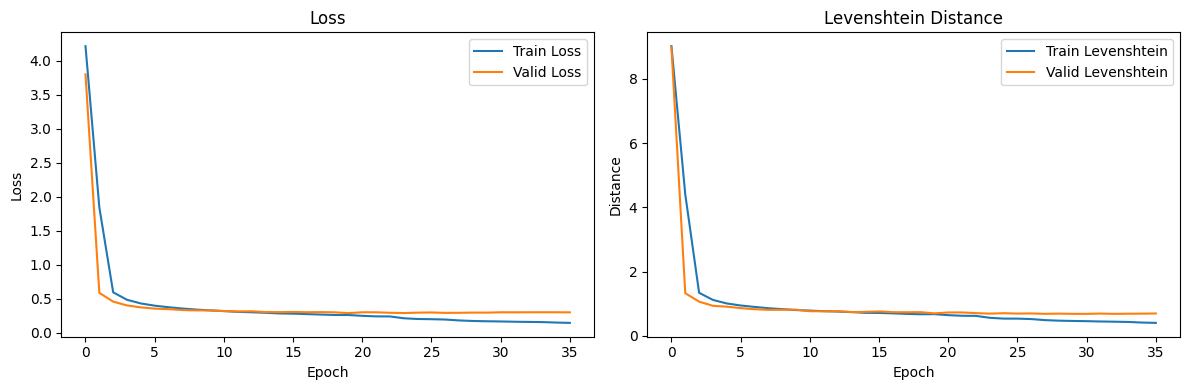

In [ ]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_distance'], label='Train Levenshtein')
plt.plot(history['valid_distance'], label='Valid Levenshtein')
plt.title('Levenshtein Distance')
plt.xlabel('Epoch')
plt.ylabel('Distance')
plt.legend()

plt.tight_layout()
plt.show()


Ниже показан график распределения количества примеров в зависимости от расстояния Левештейна

![alt text](image-3.png)

In [ ]:
# производим предсказание для Submission:

def predict(audio_id, model):
    
    with zipfile.ZipFile(ZIP_DIR, 'r') as zf:
        
        archive_path = f"morse_dataset/{audio_id}"
        data = zf.read(archive_path)

    
    y, sr = librosa.load(io.BytesIO(data), sr=16000)

    # извлекаем признаки
    feats = extract_features_enhanced(y, sr)  

    
    X = torch.from_numpy(feats.copy()).float().unsqueeze(0).to(device)
    lengths = torch.tensor([feats.shape[0]], device=device)

    # Прямой проход и декодирование
    with torch.no_grad():
        out = model(X, lengths)               # [1, T, C]
        pred = decode_predictions(out)[0]     

    return pred

def make_predictions_for_test():
    df_test = pd.read_csv(TEST_CSV)
    results = []
    for _, row in df_test.iterrows():
        audio_id = row['id']  
        pred_msg  = predict(audio_id, model)
        results.append({'id': audio_id, 'message': pred_msg})

    pd.DataFrame(results).to_csv('sample_submission.csv', index=False)

make_predictions_for_test()
